In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# GradCAM implementation
import cv2

In [14]:
def get_device():
    """Get the best available device."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"CUDA device detected: {torch.cuda.get_device_name()}")
        return device
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("MPS device detected (Apple Silicon)")
        return device
    else:
        print("No GPU available, using CPU")
        return torch.device("cpu")

In [30]:
class ResNet50FineTuned(nn.Module):
    """ResNet50 with ImageNet pretrained weights, fine-tuning only the last layer."""
    
    def __init__(self, num_classes=2, freeze_features=True):
        super(ResNet50FineTuned, self).__init__()
        
        # Load pretrained ResNet50
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Freeze all layers except the final classifier if freeze_features=True
        if freeze_features:
            for param in self.resnet50.parameters():
                param.requires_grad = False
        
        # Replace the final fully connected layer
        # ResNet50 has 2048 features in the final layer
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)
        
        # Ensure the final layer is trainable
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.resnet50(x)

In [31]:
class ChestXrayDataset:
    """Simple dataset class for loading chest x-ray images."""
    def __init__(self, root_dir, transform=None, max_samples_per_class=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = []
        
        # Get class directories
        class_dirs = [d for d in os.listdir(root_dir) 
                     if os.path.isdir(os.path.join(root_dir, d))]
        class_dirs.sort()
        self.class_names = class_dirs
        
        # Create mapping from class name to index
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_dirs)}
        
        # Collect all image paths and labels
        for class_name in class_dirs:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            class_images = []
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    class_images.append(os.path.join(class_dir, img_name))
            
            # Limit samples if specified
            if max_samples_per_class and len(class_images) > max_samples_per_class:
                random.seed(42)
                class_images = random.sample(class_images, max_samples_per_class)
            
            for img_path in class_images:
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
        
        print(f"Found {len(self.class_names)} classes: {self.class_names}")
        print(f"Total samples: {len(self.image_paths)}")

In [32]:
class GradCAM:
    """GradCAM implementation for visualization."""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.forward_hook = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = self.target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, class_idx=None):
        """Generate GradCAM heatmap."""
        # Enable gradients and set model to train mode for gradient computation
        input_image.requires_grad_(True)
        self.model.train()
        
        # Reset gradients and activations
        self.gradients = None
        self.activations = None
        
        # Forward pass
        output = self.model(input_image)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        elif isinstance(class_idx, torch.Tensor):
            class_idx = class_idx.item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass on the specific class score
        class_score = output[0, class_idx]
        class_score.backward(retain_graph=True)
        
        # Check if gradients and activations were captured
        if self.gradients is None:
            raise RuntimeError("Gradients were not captured. Check hook registration.")
        if self.activations is None:
            raise RuntimeError("Activations were not captured. Check hook registration.")
        
        # Generate CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]
        
        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(1, 2))  # [C]
        
        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)  # [H, W]
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        
        # Apply ReLU
        cam = F.relu(cam)
        
        # Normalize
        if cam.max() > 0:
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        # Set model back to eval mode
        self.model.eval()
        
        return cam.detach().cpu().numpy()
    
    def remove_hooks(self):
        """Remove the registered hooks."""
        self.forward_hook.remove()
        self.backward_hook.remove()

In [33]:
def load_model(model_path, device, num_classes=2):
    """Load the trained ResNet50 model."""
    model = ResNet50FineTuned(num_classes=num_classes, freeze_features=True)
    
    # Load the state dict
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint)
        print(f"Model loaded from {model_path}")
    else:
        raise FileNotFoundError(f"Model checkpoint not found at {model_path}")
    
    model.to(device)
    model.eval()
    return model

In [34]:
def overlay_heatmap(heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlay a heatmap on an image using OpenCV for proper GradCAM visualization.
    
    Args:
        heatmap (numpy.ndarray): The heatmap to overlay (0-1 normalized)
        image (numpy.ndarray): The original image (0-1 normalized RGB)
        alpha (float): Transparency factor for the heatmap (0-1)
        colormap: OpenCV colormap to apply to the heatmap
    
    Returns:
        tuple: (colored_heatmap, overlaid_image)
    """
    # Ensure image is in the right format (0-255 uint8)
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Ensure heatmap is in the right format (0-255 uint8)
    if heatmap.max() <= 1.0:
        heatmap = (heatmap * 255).astype(np.uint8)
    else:
        heatmap = heatmap.astype(np.uint8)
    
    # Resize heatmap to match image size if needed
    if heatmap.shape != image.shape[:2]:
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # Apply colormap to heatmap
    colored_heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Convert BGR to RGB for display
    colored_heatmap_rgb = cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB)
    
    # Ensure image is RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = image
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Create overlay using addWeighted
    overlay = cv2.addWeighted(image_rgb, 1-alpha, colored_heatmap_rgb, alpha, 0)
    
    return colored_heatmap_rgb, overlay

In [35]:
def apply_gradcam_to_images(model, dataset, device, samples_per_class=5, save_dir="./gradcam_results"):
    """Apply GradCAM to sample images from each class and save results."""
    
    # Create save directory
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Get the target layer (last convolutional layer before avgpool)
    target_layer = model.resnet50.layer4[-1].conv3  # Last conv layer in ResNet50
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    try:
        # Image transforms
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize,
        ])
        
        # Transform for display (without normalization)
        display_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        
        # Group images by class
        class_indices = {class_idx: [] for class_idx in range(len(dataset.class_names))}
        for idx, label in enumerate(dataset.labels):
            class_indices[label].append(idx)
        
        # Sample from each class
        random.seed(42)
        selected_indices = []
        for class_idx, indices in class_indices.items():
            available_samples = min(samples_per_class, len(indices))
            if available_samples > 0:
                sampled = random.sample(indices, available_samples)
                selected_indices.extend(sampled)
                print(f"Selected {available_samples} samples from class '{dataset.class_names[class_idx]}'")
        
        print(f"\nTotal images to process: {len(selected_indices)}")
        
        for i, idx in enumerate(selected_indices):
            print(f"Processing image {i+1}/{len(selected_indices)}")
            
            try:
                # Load and preprocess image
                img_path = dataset.image_paths[idx]
                true_label = dataset.labels[idx]
                class_name = dataset.class_names[true_label]
                
                # Load original image
                original_img = Image.open(img_path).convert('RGB')
                
                # Prepare for model
                input_tensor = transform(original_img).unsqueeze(0).to(device)
                
                # Prepare for display
                display_img = display_transform(original_img)
                display_img_np = display_img.permute(1, 2, 0).numpy()
                
                # Get prediction (with model in eval mode)
                model.eval()
                with torch.no_grad():
                    output = model(input_tensor)
                    probabilities = F.softmax(output, dim=1)
                    predicted_class = output.argmax(dim=1).item()
                    confidence = probabilities[0, predicted_class].item()
                
                print(f"  True: {class_name}, Predicted: {dataset.class_names[predicted_class]} ({confidence:.3f})")
                
                # Generate GradCAM
                cam = grad_cam.generate_cam(input_tensor, predicted_class)
                
                # Create proper overlay using OpenCV
                colored_heatmap, overlay_img = overlay_heatmap(cam, display_img_np, alpha=0.4)
                
                # Create visualization
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                # Original image
                axes[0].imshow(display_img_np)
                axes[0].set_title(f'Original Image\nTrue: {class_name}')
                axes[0].axis('off')
                
                # GradCAM heatmap
                im1 = axes[1].imshow(colored_heatmap)
                axes[1].set_title(f'GradCAM Heatmap\nPred: {dataset.class_names[predicted_class]} ({confidence:.3f})')
                axes[1].axis('off')
                
                # Proper overlay using OpenCV addWeighted
                axes[2].imshow(overlay_img)
                axes[2].set_title(f'Overlay (OpenCV addWeighted)\nFocus Areas')
                axes[2].axis('off')
                
                # Add overall title with prediction info
                fig.suptitle(f'GradCAM Analysis - {class_name} Case {sum(1 for j in range(i+1) if dataset.labels[selected_indices[j]] == true_label)}\n'
                            f'File: {os.path.basename(img_path)}\n'
                            f'Prediction: {dataset.class_names[predicted_class]} (Confidence: {confidence:.3f})', 
                            fontsize=12)
                
                plt.tight_layout()
                
                # Save the figure with class info
                save_path = os.path.join(save_dir, f'gradcam_{class_name.lower()}_{sum(1 for j in range(i+1) if dataset.labels[selected_indices[j]] == true_label)}.png')
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"  Saved: {save_path}")
                
                plt.show()
                plt.close()
                
            except Exception as e:
                print(f"  ❌ Error processing image {i+1}: {e}")
                continue
    
    finally:
        # Clean up hooks
        try:
            grad_cam.remove_hooks()
            print("Hooks removed successfully")
        except:
            pass

In [36]:
def main():
    """Main function for GradCAM visualization."""
    device = get_device()
    
    # Configuration
    config = {
        "model_path": "C:/Users/sriha/NEU/shlabs/HP_NVIDIA/openMed/src/nb/checkpoints/best_resnet50_finetuned.pth",
        "data_path": "C:/Users/sriha/NEU/shlabs/HP_NVIDIA/CellData/chest_xray/test",
        "num_classes": 2,
        "num_images": 5,  # Number of images per class to analyze
        "save_dir": "./gradcam_results"
    }
    
    print("=== ResNet50 GradCAM Visualization ===")
    print(f"Loading model from: {config['model_path']}")
    print(f"Loading test data from: {config['data_path']}")
    
    # Load the trained model
    try:
        model = load_model(config["model_path"], device, config["num_classes"])
        print("✓ Model loaded successfully")
    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        print("Make sure you have trained the model first using resnet50.py")
        return
    
    # Load test dataset
    try:
        dataset = ChestXrayDataset(
            root_dir=config["data_path"],
            max_samples_per_class=50  # Limit for visualization, but allow more to choose from
        )
        print("✓ Test dataset loaded successfully")
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return
    
    # Apply GradCAM
    print(f"\nApplying GradCAM to {config['num_images']} samples from each class...")
    print(f"Expected: {config['num_images']} Normal + {config['num_images']} Pneumonia = {config['num_images'] * 2} total images")
    apply_gradcam_to_images(
        model=model,
        dataset=dataset,
        device=device,
        samples_per_class=config["num_images"],
        save_dir=config["save_dir"]
    )
    
    print(f"\n✓ GradCAM analysis complete!")
    print(f"Results saved in: {config['save_dir']}")
    print("\nGradCAM shows which parts of the chest X-rays the model focuses on for classification.")
    print("Red areas indicate high importance, blue areas indicate low importance.")
    print("Files are saved as: gradcam_normal_1.png, gradcam_normal_2.png, gradcam_pneumonia_1.png, etc.")


CUDA device detected: NVIDIA GeForce RTX 3060 Laptop GPU
=== ResNet50 GradCAM Visualization ===
Loading model from: C:/Users/sriha/NEU/shlabs/HP_NVIDIA/openMed/src/nb/checkpoints/best_resnet50_finetuned.pth
Loading test data from: C:/Users/sriha/NEU/shlabs/HP_NVIDIA/CellData/chest_xray/test
Model loaded from C:/Users/sriha/NEU/shlabs/HP_NVIDIA/openMed/src/nb/checkpoints/best_resnet50_finetuned.pth
✓ Model loaded successfully
Found 2 classes: ['NORMAL', 'PNEUMONIA']
Total samples: 100
✓ Test dataset loaded successfully

Applying GradCAM to 5 samples from each class...
Expected: 5 Normal + 5 Pneumonia = 10 total images
Selected 5 samples from class 'NORMAL'
Selected 5 samples from class 'PNEUMONIA'

Total images to process: 10
Processing image 1/10
  True: NORMAL, Predicted: NORMAL (0.924)
  Saved: ./gradcam_results\gradcam_normal_1.png


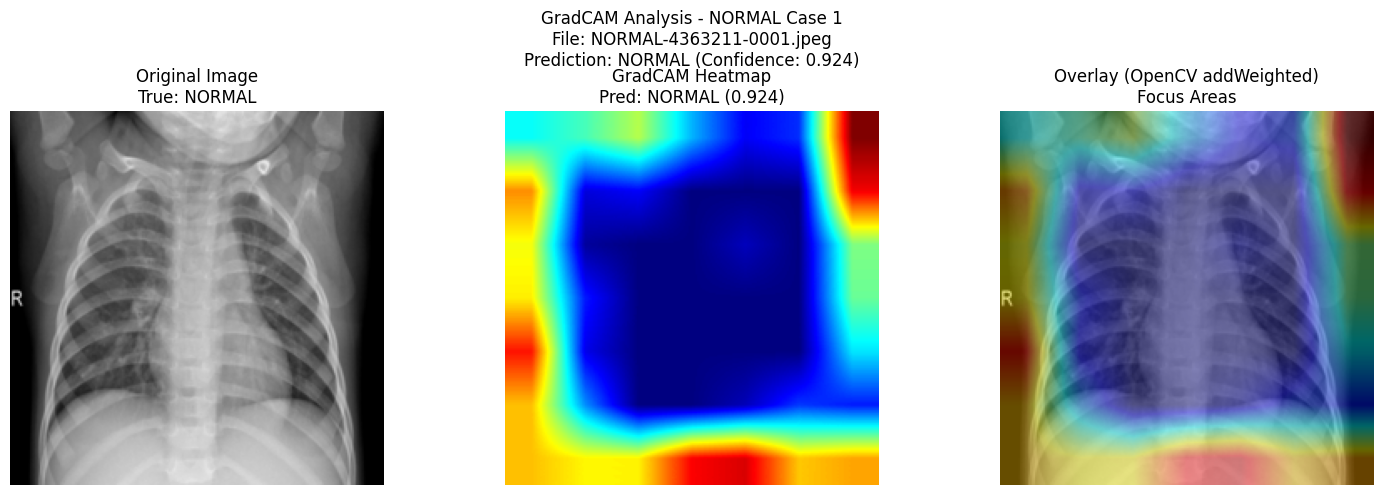

Processing image 2/10
  True: NORMAL, Predicted: NORMAL (0.987)
  Saved: ./gradcam_results\gradcam_normal_2.png


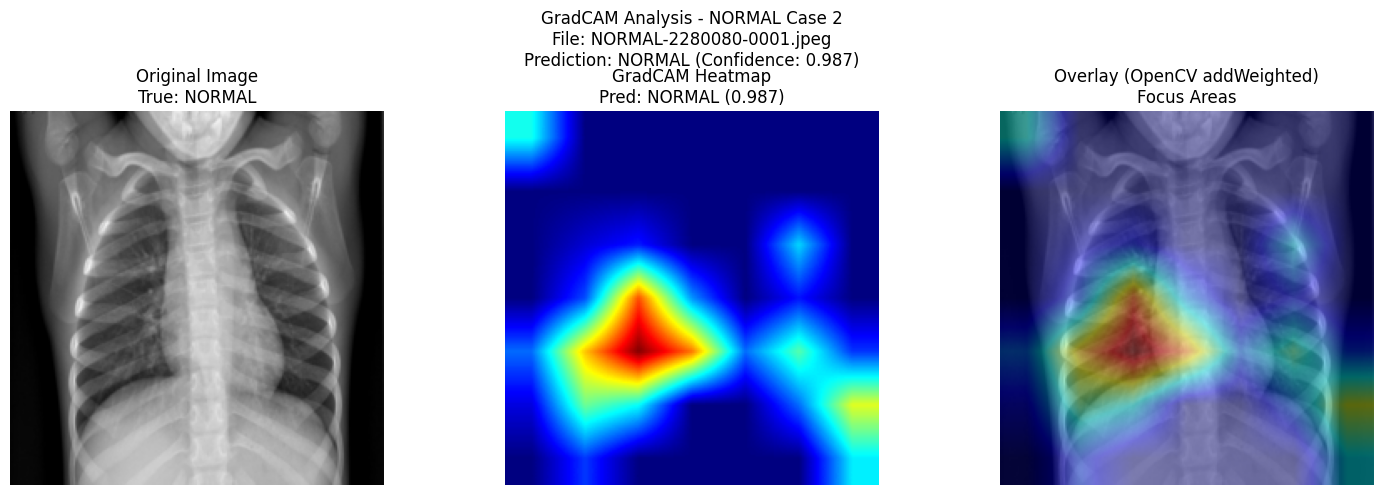

Processing image 3/10
  True: NORMAL, Predicted: PNEUMONIA (0.639)
  Saved: ./gradcam_results\gradcam_normal_3.png


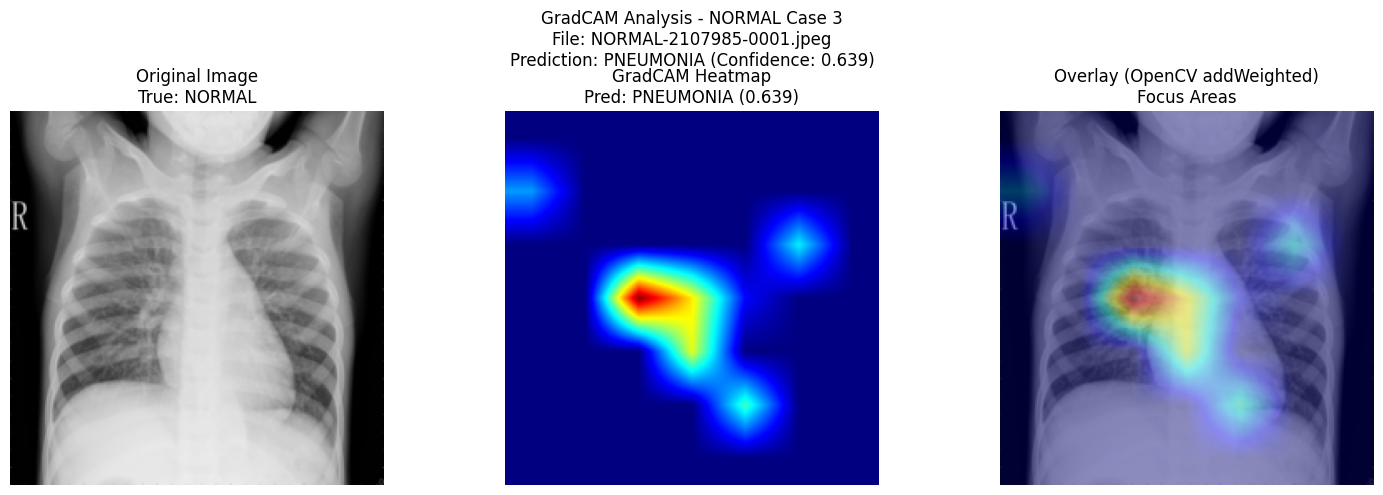

Processing image 4/10
  True: NORMAL, Predicted: NORMAL (0.504)
  Saved: ./gradcam_results\gradcam_normal_4.png


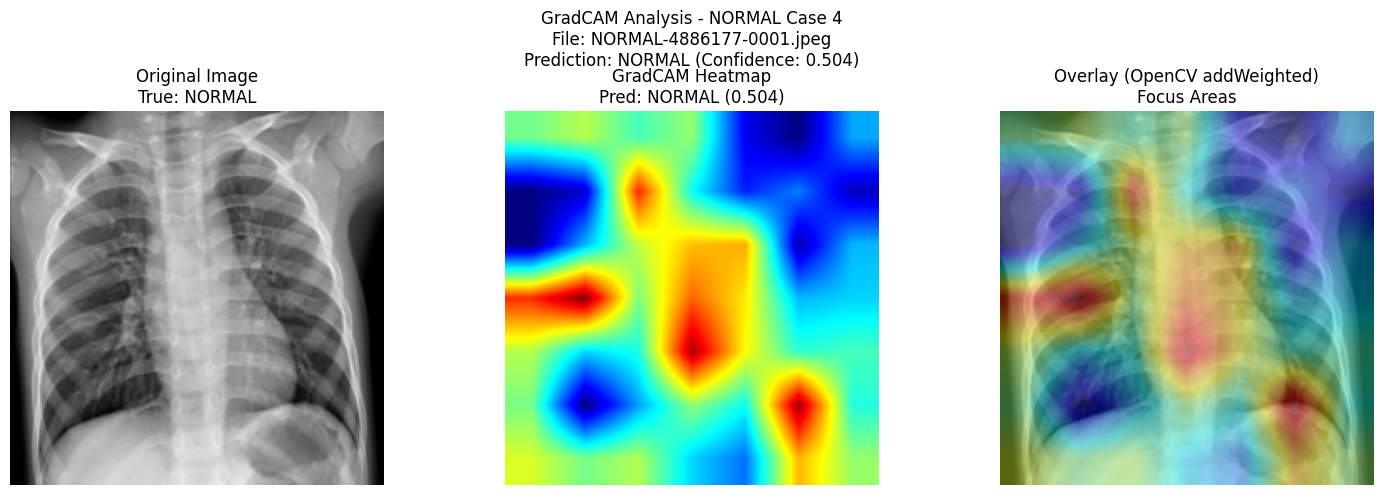

Processing image 5/10
  True: NORMAL, Predicted: NORMAL (0.543)
  Saved: ./gradcam_results\gradcam_normal_5.png


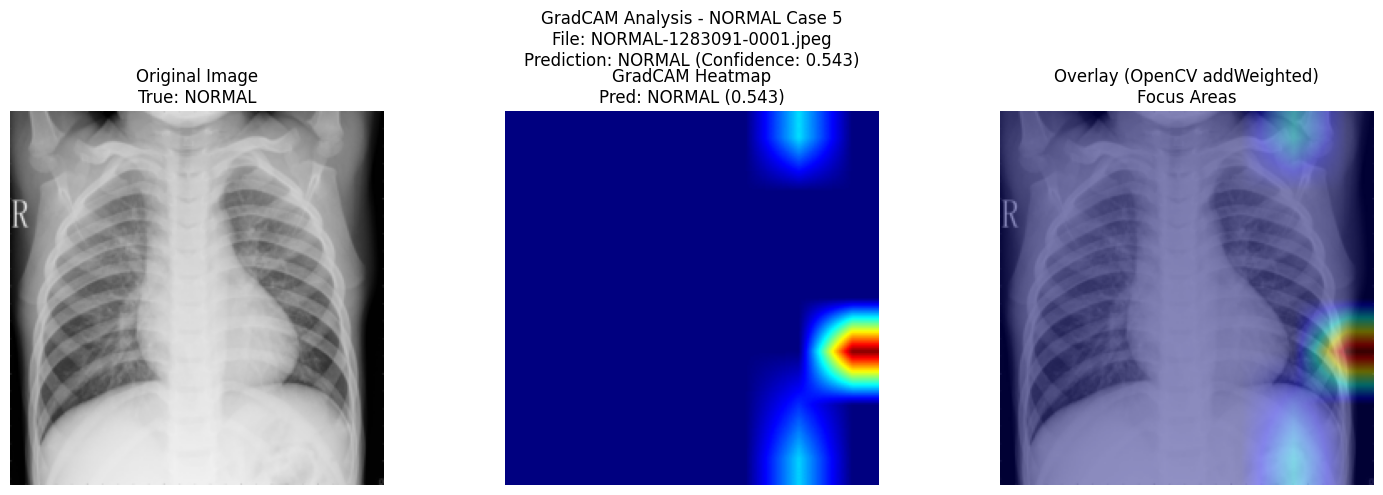

Processing image 6/10
  True: PNEUMONIA, Predicted: PNEUMONIA (0.993)
  Saved: ./gradcam_results\gradcam_pneumonia_1.png


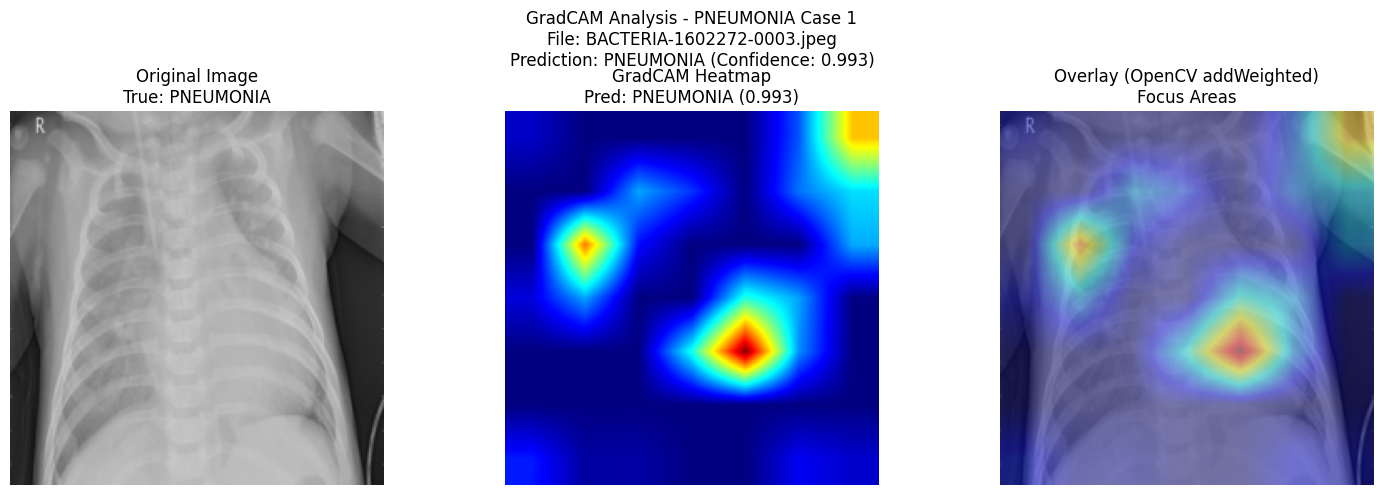

Processing image 7/10
  True: PNEUMONIA, Predicted: PNEUMONIA (0.990)
  Saved: ./gradcam_results\gradcam_pneumonia_2.png


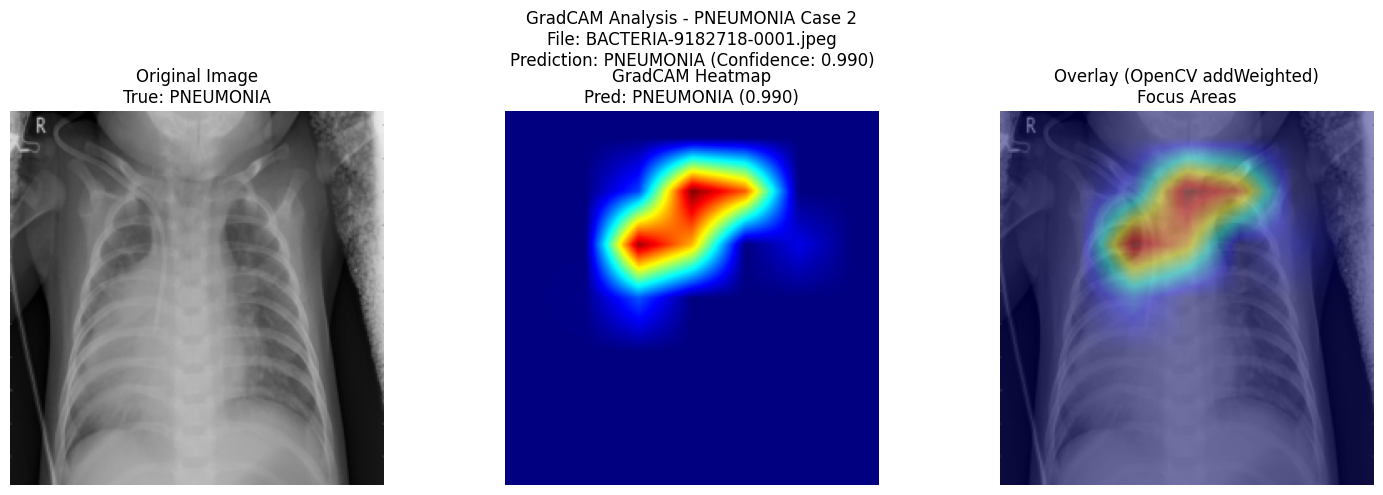

Processing image 8/10
  True: PNEUMONIA, Predicted: PNEUMONIA (0.964)
  Saved: ./gradcam_results\gradcam_pneumonia_3.png


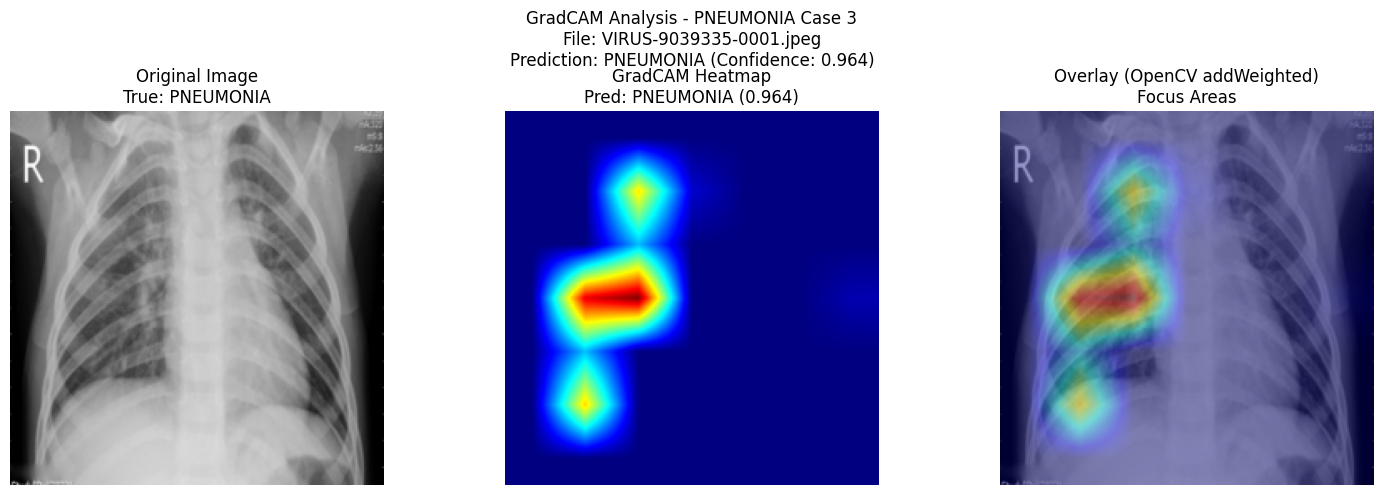

Processing image 9/10
  True: PNEUMONIA, Predicted: PNEUMONIA (0.815)
  Saved: ./gradcam_results\gradcam_pneumonia_4.png


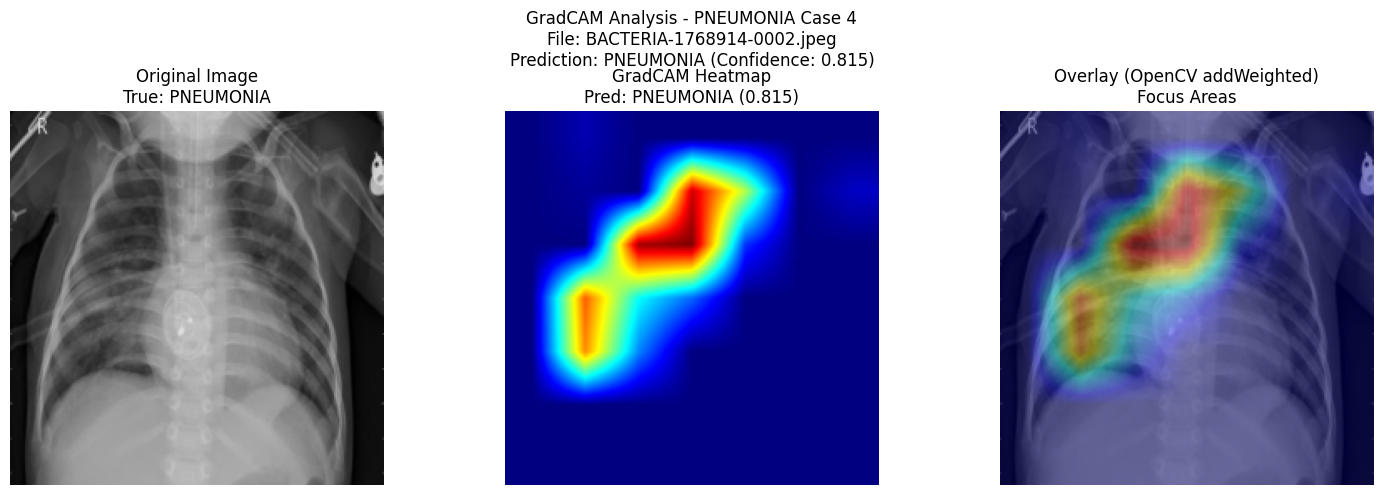

Processing image 10/10
  True: PNEUMONIA, Predicted: PNEUMONIA (0.972)
  Saved: ./gradcam_results\gradcam_pneumonia_5.png


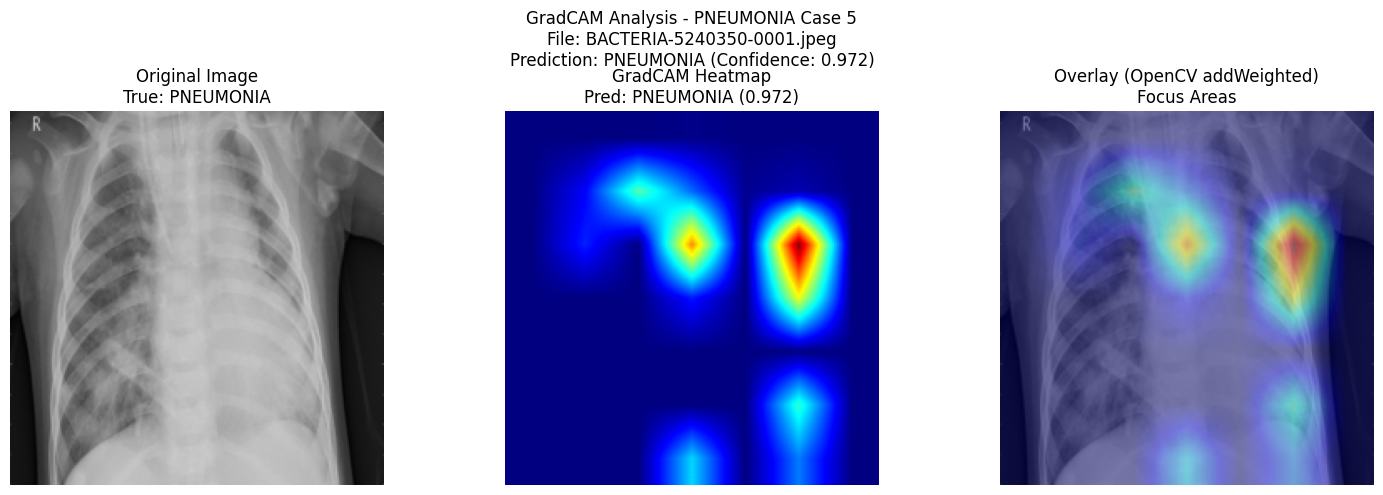

Hooks removed successfully

✓ GradCAM analysis complete!
Results saved in: ./gradcam_results

GradCAM shows which parts of the chest X-rays the model focuses on for classification.
Red areas indicate high importance, blue areas indicate low importance.
Files are saved as: gradcam_normal_1.png, gradcam_normal_2.png, gradcam_pneumonia_1.png, etc.


In [37]:
main()